In [1]:
# Load Packages
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from time import sleep
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from pandas.plotting import autocorrelation_plot
%matplotlib inline

In [2]:
#Importing test and train datasets
train = data.DataReader(['AAPL'], 'yahoo', start='2016/10/01', end='2020/10/01')
test = data.DataReader(['AAPL'], 'yahoo', start='2020/10/01', end='2021/10/01')

data2 = data.DataReader(['AAPL'], 'yahoo', start='2016/10/01', end='2021/10/01')

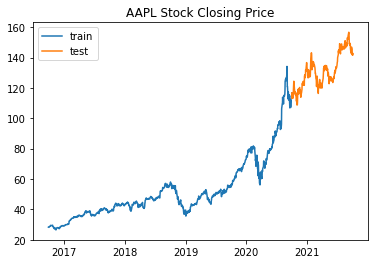

In [3]:
# Only using Closing price
test = test['Close']
train = train['Close']
data2 = data2['Close']

plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.legend()
plt.title("AAPL Stock Closing Price")
plt.show()

In [4]:
#Number of rows in each data set
print(len(train))
print(len(test))

1008
254


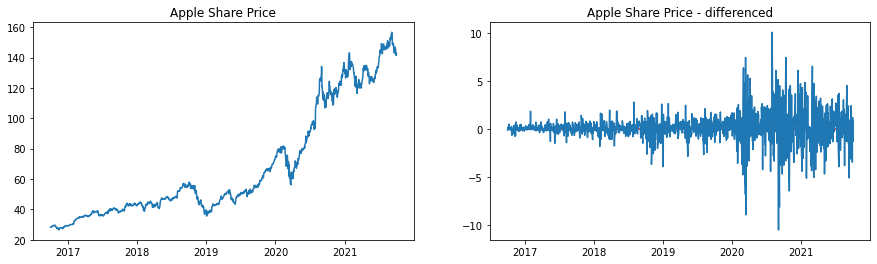

In [5]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
data2['differenced'] = data2['AAPL'].diff()
train['differenced'] = train['AAPL'].diff()
test['differenced'] = test['AAPL'].diff()
# Levels
axes[0].plot(data2.index._mpl_repr(), data2['AAPL'], '-')
axes[0].set(title='Apple Share Price')

# Log difference
axes[1].plot(data2.index._mpl_repr(), data2['differenced'], '-')

axes[1].hlines(0, data2.index[0], data2.index[-1], 'r')
axes[1].set(title='Apple Share Price - differenced');

In [6]:
from statsmodels.tsa.stattools import adfuller
#Using Augmented Dickey-Fuller test to find value of d
#Augmented Dickey-Fuller test on Apple closing stock prices
result = adfuller(data2['AAPL'])
print('Results for Apple closing stock prices')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#Augmented Dickey-Fuller test on DIFFERENCED Apple closing stock prices
result = adfuller(data2['differenced'][1:])
print('Results for Differenced Apple closing stock prices')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Results for Apple closing stock prices
ADF Statistic: 0.122152
p-value: 0.967541
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Results for Differenced Apple closing stock prices
ADF Statistic: -7.296031
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


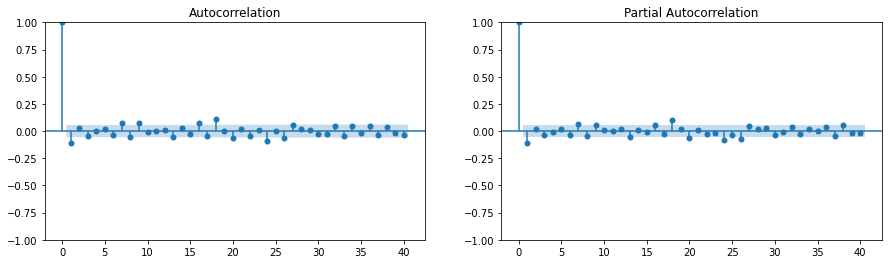

In [7]:
#Plot ACF and PACF to find value of p and q
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data2['differenced'][1:], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data2['differenced'][1:], lags=40, ax=axes[1])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3372.215, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3382.421, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3367.800, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3369.130, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3385.051, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3368.366, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3368.243, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3370.199, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3371.746, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.746 seconds


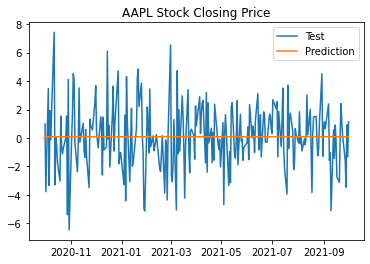

In [11]:
#Using auto_arima to find optimal parameters and train model

from pmdarima import auto_arima
model = auto_arima(train['differenced'][1:], trace=True, seasonal=True, start_P=1, D=1, start_Q=1, error_action='ignore', suppress_warnings=True)
model.fit(train['differenced'])

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
#plt.plot(train, label='Train')
plt.plot(test['differenced'], label='Test')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.title("AAPL Stock Closing Price")
plt.show()

MSE: 4.988363


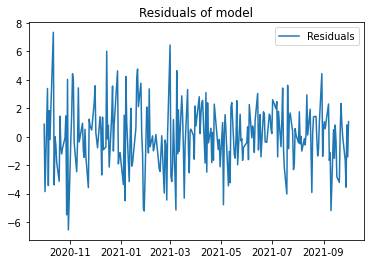

,residuals
Date,
2020-09-30,NaN
2020-10-01,0.877527
2020-10-02,-3.856016
2020-10-05,3.391886
2020-10-06,-3.427845
...,...
2021-09-27,-1.637882
2021-09-28,-3.547870
2021-09-29,0.832119


In [20]:
#Finding Mean Squared Error and Residuals
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['differenced'][1:], forecast['Prediction'][1:])
print('MSE: %f' % mse)

residuals = pd.DataFrame()
residuals['residuals'] = test['differenced'] - forecast['Prediction']
plt.plot(residuals['residuals'], label='Residuals')
plt.legend()
plt.title("Residuals of model")
plt.show()

residuals

In [24]:
#Importing Google Trends Data
trend = pd.read_csv('apple_trend.csv')
trend.head()

,date,Apple
0,10/1/2016 0:00,94
1,10/1/2016 1:00,93
2,10/1/2016 2:00,90
3,10/1/2016 3:00,85
4,10/1/2016 4:00,78


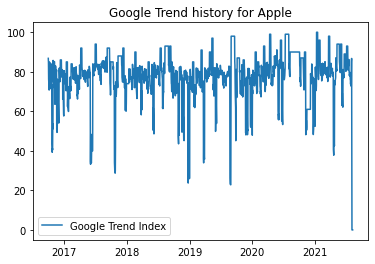

In [25]:
#Cleaning up the trend data so it is by day
def process_df(df):
    df.index = pd.to_datetime(df['date'])
    df2 = df.resample('D').mean().pad()
    #df2 = df2.drop(['isPartial'], axis = 1)
    return df2

apple_trend = process_df(trend)

plt.plot(apple_trend, label='Google Trend Index')
plt.legend()
plt.title("Google Trend history for Apple")
plt.show()

<AxesSubplot:>

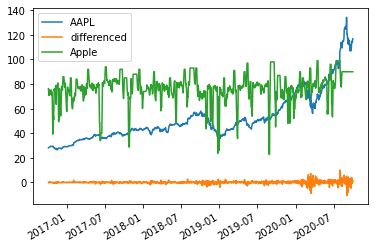

In [26]:
#Merging the 2 dataframes to append the google trend data to our training dataset
apple_combined_train = train.merge(apple_trend, left_index=True, right_index=True)
apple_combined_test = test.merge(apple_trend, left_index=True, right_index=True)

#apple_combined_train = apple_combined_train.asfreq('d')
#apple_combined_test = apple_combined_test.asfreq('d')

apple_combined_train.plot()

In [27]:
trend_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 14)
model = sm.tsa.statespace.SARIMAX(apple_combined_train['AAPL'], exog = apple_combined_train['Apple'], 
                                  order = trend_order, seasonal_order = seasonal_order)

# fit model
model_fit = model.fit()
print(model_fit.summary())

C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                      
Dep. Variable:                               AAPL   No. Observations:                 1007
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -1682.501
Date:                            Wed, 24 Nov 2021   AIC                           3377.003
Time:                                    14:02:38   BIC                           3406.401
Sample:                                         0   HQIC                          3388.180
                                           - 1007                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Apple          0.0043      0.005      0.832      0.406      -0.006       0.014
ar.L1         -0.3743      0.105   

In [28]:
forecast = model_fit.predict(start=len(apple_combined_train['AAPL']), end=len(apple_combined_train['AAPL']) + len(apple_combined_test['AAPL']) - 1, exog = apple_combined_test['Apple'])

forecast.index = apple_combined_test.index

C:\Users\alvin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


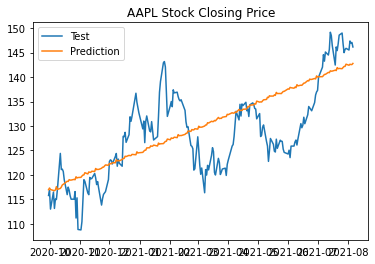

In [95]:
plt.plot(apple_combined_test['AAPL'], label='Test')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.title("AAPL Stock Closing Price")
plt.show()

MSE: 47.929595


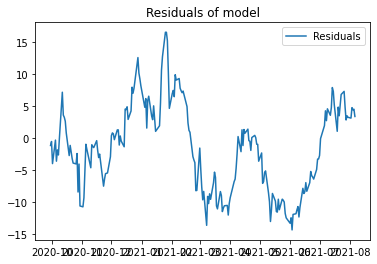

,AAPL,Prediction,residuals
Date,,,
2020-09-30,NaN,NaN,-1.163604
2020-10-01,NaN,NaN,-0.542707
2020-10-02,NaN,NaN,-3.992843
2020-10-05,NaN,NaN,-0.326512
2020-10-06,NaN,NaN,-3.615436
...,...,...,...
2021-09-27,NaN,NaN,NaN
2021-09-28,NaN,NaN,NaN
2021-09-29,NaN,NaN,NaN


In [96]:
#Finding Mean Squared Error and Residuals
mse = mean_squared_error(apple_combined_test['AAPL'], forecast)
print('MSE: %f' % mse)

residuals['residuals'] = apple_combined_test['AAPL'] - forecast
plt.plot(residuals['residuals'], label='Residuals')
plt.legend()
plt.title("Residuals of model")
plt.show()

residuals